In [ ]:
!pip install datasets

#import Libraries

In [ ]:
import os
import re
import time
import json
import random
import string
import psutil
import pickle
from tqdm import tqdm
from pprint import pprint
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mode

from datasets import load_dataset
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, normalizers, decoders, processors
import tiktoken

import torch
from torch.utils.data import TensorDataset, Dataset, IterableDataset, DataLoader

from dataclasses import dataclass

from datasets import load_dataset
from tokenizers import Tokenizer

import matplotlib.pyplot as plt

from torch import nn
from torch.nn import functional as F

#Utils

In [ ]:
def get_sample(dataset):
    # Randomly select an index from the training dataset
    idx = random.randint(0, len(dataset['train']))

    # Return the "text" field of the randomly selected training sample
    return dataset['train'][idx]['text']

In [ ]:
def prepare_data(tokens, seq_len):
    # Trim tokens so that total length is divisible by seq_len
    n_tokens = (tokens.shape[0] // seq_len) * seq_len
    tokens = tokens[:n_tokens]

    # Reshape to 2D tensor
    return tokens.view(-1, seq_len)

In [ ]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [ ]:
def calculate_time(model, x, num_runs=10):
    torch.cuda.synchronize()
    start = time.time()
    for _ in range(num_runs):
        model(*x)
    torch.cuda.synchronize()
    return (time.time() - start) / num_runs

#Init

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

#Loading dataset

In [ ]:
dataset = load_dataset("roneneldan/TinyStories")
dataset

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00004-2d5a1467fff108(…):   0%|          | 0.00/249M [00:00<?, ?B/s]

data/train-00001-of-00004-5852b56a2bd28f(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/train-00002-of-00004-a26307300439e9(…):   0%|          | 0.00/246M [00:00<?, ?B/s]

data/train-00003-of-00004-d243063613e5a0(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/validation-00000-of-00001-869c898b5(…):   0%|          | 0.00/9.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 2119719
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 21990
    })
})

#Analysis of Dataset

In [ ]:
sample = get_sample(dataset)
pprint(sample)

('Once upon a time, there was a pretty flower called a poppy. It was red and '
 'had a black dot in the middle. One day, the poppy started to look sad and '
 'droopy. It was not moving anymore.\n'
 '\n'
 'The little girl who loved the poppy saw that it was not the same. She went '
 'to her mommy and said, "Mommy, the poppy is dead. It needs help." Her mommy '
 "said they could change the poppy's home to a new place with more sun and "
 'water.\n'
 '\n'
 'So they dug up the poppy and moved it to a new home. After a few days, the '
 'poppy started to change. It was not dead anymore! It was happy and bright '
 'again. The little girl was so happy to see her poppy alive and well.')


#Measuring RAM Usage After Dataset Loading

In [ ]:
# RAM before
process = psutil.Process(os.getpid())
ram_before = process.memory_info().rss  # in bytes

# Load dataset
dataset = load_dataset("roneneldan/TinyStories")

# RAM after
ram_after = process.memory_info().rss

# Result
ram_used = ram_after - ram_before
print(f"🔹 RAM used for loading dataset: {ram_used / (1024**2):.2f} MB")

🔹 RAM used for loading dataset: 135.50 MB


In [ ]:
# RAM After
process = psutil.Process(os.getpid())
ram_before = process.memory_info().rss  # in bytes

# Load full dataset into memory
train = list(dataset["train"])
val = list(dataset["validation"])

# RAM after
ram_after = process.memory_info().rss

# Result
ram_used = ram_after - ram_before
print(f"🔹 RAM used for loading full dataset into memory: {ram_used / (1024**3):.2f} GB")

🔹 RAM used for loading full dataset into memory: 4.12 GB


#Train Tokenizer

In [ ]:
# from tokenizers import Tokenizer, models, trainers, pre_tokenizers, processors, decoders

# tok = Tokenizer(models.Unigram())
# tok.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)

# trainer = trainers.UnigramTrainer(
#     vocab_size=4000,                # 2k–8k خوبه
#     unk_token="|<unk>|",
#     special_tokens=["|<unk>|", "<|endoftext|>"]
# )
# tok.train_from_iterator(dataset["train"]["text"], trainer=trainer)
# tok.post_processor = processors.TemplateProcessing(
#     single="<|endoftext|> $A",
#     special_tokens=[("<|endoftext|>", tok.token_to_id("<|endoftext|>"))],
# )
# tok.decoder = decoders.ByteLevel(add_prefix_space=False)
# tok.save("unigram_4k.json")
# print("vocab:", tok.get_vocab_size())

#loading jason file

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# path = "/content/drive/MyDrive/unigram_4k.json"


In [ ]:
from tokenizers import Tokenizer

# The path in My Drive
json_path = "/content/drive/MyDrive/unigram_4k.json"

tokenizer = Tokenizer.from_file(json_path)
print("vocab:", tokenizer.get_vocab_size())


vocab: 4000


In [ ]:
from pprint import pprint

sent = 'They played together all day and became best friends.'

tok_uni = Tokenizer.from_file("/content/drive/MyDrive/unigram_4k.json")

# tokennization
tokens = tok_uni.encode(sent)

print(tokens.ids)       # ids
print(tokens.tokens)    # tokens

#   decoding from ids to text
pprint(tok_uni.decode(tokens.ids))

[1, 136, 198, 113, 76, 29, 7, 369, 219, 75, 3]
['<|endoftext|>', 'They', 'Ġplayed', 'Ġtogether', 'Ġall', 'Ġday', 'Ġand', 'Ġbecame', 'Ġbest', 'Ġfriends', '.']
'They played together all day and became best friends.'


In [ ]:
list_sent = ['They played together all day and became best friends.',
             'They played together all day and became best friends.',
             'They played together all day and became best friends.']
string = ' <|endoftext|> '.join(list_sent) + ' <|endoftext|>'
print(string)
print(tokenizer.encode(string).ids)

They played together all day and became best friends. <|endoftext|> They played together all day and became best friends. <|endoftext|> They played together all day and became best friends. <|endoftext|>
[1, 136, 198, 113, 76, 29, 7, 369, 219, 75, 3, 2, 1, 23, 198, 113, 76, 29, 7, 369, 219, 75, 3, 2, 1, 23, 198, 113, 76, 29, 7, 369, 219, 75, 3, 2, 1]


In [ ]:
# total_tokens = len(tokenized_train_samples)  # extend
# print("Total tokens in this subset:", total_tokens)

NameError: name 'tokenized_train_samples' is not defined

#Train

In [ ]:
import torch
from tqdm.auto import tqdm

N = 1000000  # number of samples

# Tokenization {train} - just 1000 items
tokenized_train_samples = []
for i, item in enumerate(tqdm(dataset["train"], desc="Tokenizing Train Set"), start=1):
    input_ids = tokenizer.encode(item["text"]).ids
    tokenized_train_samples.extend(input_ids)  #
    if i >= N:
        break

# Save tokens as a pytorch file
torch.save(torch.tensor(tokenized_train_samples, dtype=torch.int32),
           'tokenized-train-samples_vocab-10k.pt')

Tokenizing Train Set:   0%|          | 0/2119719 [00:00<?, ?it/s]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# copy from colab to Google Drive
!cp /content/tokenized-train-samples_vocab-10k.pt /content/drive/MyDrive/


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# from google.colab import drive
# import torch

# # اتصال به درایو
# drive.mount('/content/drive')

# # مسیر ذخیره در درایو
# save_path = '/content/drive/MyDrive/tokenized-train-samples_vocab-10k.pt'

# # ذخیره‌سازی
# torch.save(torch.tensor(tokenized_train_samples, dtype=torch.int32), save_path)
# print(f"✅ فایل ذخیره شد: {save_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ فایل ذخیره شد: /content/drive/MyDrive/tokenized-train-samples_vocab-10k.pt


In [ ]:
N = 10000  # number of samples

# Tokenization {train}
tokenized_train_samples = []
for i, item in enumerate(tqdm(dataset["validation"], desc="Tokenizing Valid Set"), start=1):
    input_ids = tokenizer.encode(item["text"]).ids
    tokenized_train_samples.extend(input_ids)  #
    if i >= N:
        break

# Save tokens as a pytorch file
torch.save(torch.tensor(tokenized_train_samples, dtype=torch.int32),
           'tokenized-valid-samples_vocab-10k.pt')

Tokenizing Valid Set:   0%|          | 0/21990 [00:00<?, ?it/s]

In [ ]:
total_tokens = len(tokenized_train_samples)  #
print("Total tokens in this subset:", total_tokens)

Total tokens in this subset: 283211092


#Custom dataset

In [ ]:
# Load tokens from pytorch file
tokenized_train_samples = torch.load('/content/drive/MyDrive/tokenized-train-samples_vocab-10k.pt')
tokenized_valid_samples = torch.load('/content/drive/MyDrive/tokenized-valid-samples_vocab-10k.pt')
tokenized_train_samples.shape, tokenized_valid_samples.shape

(torch.Size([283211092]), torch.Size([2586183]))

In [ ]:
# # Load tokens from pytorch file
# tokenized_train_samples = torch.load('/content/tokenized-train-samples_vocab-10k.pt')
# tokenized_valid_samples = torch.load('/content/tokenized-valid-samples_vocab-10k.pt')
# tokenized_train_samples.shape, tokenized_valid_samples.shape

(torch.Size([283211092]), torch.Size([2586183]))

In [ ]:
seq_len = 128  # Desired sequence length for each row
tokenized_train_samples = prepare_data(tokenized_train_samples, seq_len)
tokenized_train_samples.shape

torch.Size([2212586, 128])

In [ ]:
train_set = TensorDataset(tokenized_train_samples[:, :-1], tokenized_train_samples[:, 1:])
train_set[60_000]

(tensor([   4,    5,    9,  120,  320,    7,   24,    8,    2,   15, 2477,    2,
            4,    5,    2,  362, 1037,   54,   39,  120,  320,   12,   48,    2,
            4,    5, 1138,   66,    3,   23,   76,  198,  113,    7,   34,    2,
           10,  299,   31,   89,    3,    6,    6,  175,   11,    9,  260,   72,
          142,    8,    9,  320,   24,  367,    2,    4,    5,   65,  120,  134,
            3,   23,   55,   48,    2,    4,    5,   68,    2,   10,  120,  134,
           25,    9, 1037,    3,   39, 1001,  320,   12,   48,   84,    3,   49,
           34,  124,    2,   10,  120,  121,    7,  120,   75,   25,    9,   52,
         1037,    3,    1,   57,   63,    2,   10,   42,    8,   44,   12,    2,
           10,  888,   43,  143,   83,  358,    3,  358,   85,    2,    4,    5,
           56,   27,   28,  185,    7,  222,   25], dtype=torch.int32),
 tensor([   5,    9,  120,  320,    7,   24,    8,    2,   15, 2477,    2,    4,
            5,    2,  362, 1037,   54

In [ ]:
# taking time for each batch
%timeit _ = next(iter(train_set))

6.33 µs ± 1.14 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


#Custom Class

In [ ]:
class TinyStoriesDataset(Dataset):

    def __init__(self, data, seq_len):
        self.seq_len = seq_len
        self.data = prepare_data(data, seq_len+1)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        sample = self.data[idx]
        return sample[:-1], sample[1:]#.long()

In [ ]:
train_set = TinyStoriesDataset(tokenized_train_samples, 128)
train_set.data.shape, len(train_set), train_set[0]

(torch.Size([2195328, 129]),
 2195328,
 (tensor([   1,   97,   29,    8,    2,   10,   43,   62,   83,   36,  124,    2,
            10, 1713,   25,   18,  196,    3,   20,  169,    2,   14,    4,   12,
          1434,    2,    4,    5,   56,   27,    2,   14,    4,    2,  203,    2,
            14,    4,   12,  918,    3,   36,   61,    2,    4,    5,  275,    9,
          1713,   27,   18,   45,    8,    2,   11,    5,   26,   87,    2,   11,
            13,   80,    2,   10,  965,    2,    5,   17,   18, 1085,    3,    6,
             6,   94,   72,    2,    4,    5,   18,   45,    7,   24,    8,    2,
            15,  249,    8,    2,   32,  124,  186, 1713,    3,  496,   33,  275,
             2,   14,    4,   27,    2,   46,   13,    7,    2,   11,   13,   80,
             2,   46,   37, 1085,   74,  243,   45,   82,    7,   24,    8,    2,
            15,  233,    8,   36,    8,    2,   80,   13], dtype=torch.int32),
  tensor([  97,   29,    8,    2,   10,   43,   62,   83,   36

In [ ]:
import torch

# tokenized_train_samples = torch.load('/content/drive/MyDrive/tokenized-train-samples_vocab-10k.pt')
# tokenized_valid_samples = torch.load('/content/drive/MyDrive/tokenized-valid-samples_vocab-10k.pt')

# the path for files
train_tokens_path = "/content/drive/MyDrive/tokenized-train-samples_vocab-10k.pt"
valid_tokens_path = "/content/drive/MyDrive/tokenized-valid-samples_vocab-10k.pt"

# loading from files
train_token_ids = torch.load(train_tokens_path)
valid_token_ids = torch.load(valid_tokens_path)

print("✅ Train tokens:", train_token_ids.shape)
print("✅ Valid tokens:", valid_token_ids.shape)

✅ Train tokens: torch.Size([283211092])
✅ Valid tokens: torch.Size([2586183])


In [ ]:
seq_len = 128

train_set = TinyStoriesDataset(train_token_ids, seq_len)
valid_set = TinyStoriesDataset(valid_token_ids, seq_len)

print(f"📊 Number of Samples")
print(f"🔹 Train: {len(train_set):,} samples")
print(f"🔹 Valid: {len(valid_set):,} samples")

📊 Number of Samples
🔹 Train: 2,195,434 samples
🔹 Valid: 20,047 samples


In [ ]:
train_token_ids

tensor([  1,  97,  29,  ..., 168, 395,   3], dtype=torch.int32)

#DataLoader

In [ ]:
tokenized_train_samples = torch.load('/content/drive/MyDrive/tokenized-train-samples_vocab-10k.pt')
tokenized_valid_samples = torch.load('/content/drive/MyDrive/tokenized-valid-samples_vocab-10k.pt')

train_set = TinyStoriesDataset(tokenized_train_samples, seq_len=128)
valid_set = TinyStoriesDataset(tokenized_valid_samples, seq_len=128)

In [ ]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, pin_memory=True)#, num_workers=4)
valid_loader = DataLoader(valid_set, batch_size=32, shuffle=False, pin_memory=True)#, num_workers=4)

In [ ]:
x_batch, y_batch = next(iter(train_loader))
x_batch.shape, y_batch.shape

(torch.Size([32, 128]), torch.Size([32, 128]))

In [ ]:
for x_batch, y_batch in train_loader:
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([32, 128]) torch.Size([32, 128])


In [ ]:
len(train_loader), len(valid_loader)

(68608, 627)

In [ ]:
# Load tokens from pytorch file
train_token_ids = torch.load('/content/drive/MyDrive/tokenized-train-samples_vocab-10k.pt')
valid_token_ids = torch.load('/content/drive/MyDrive/tokenized-valid-samples_vocab-10k.pt')

print("📊 Number of Tokens")
print(f"🔹 Train: {len(train_token_ids):,} tokens")
print(f"🔹 Valid: {len(valid_token_ids):,} tokens")

📊 Number of Tokens
🔹 Train: 283,211,092 tokens
🔹 Valid: 2,586,183 tokens


In [ ]:
x, y = next(iter(train_set))

print(f"📊 Sample Shapes")
print(f"🔹 Input: {x.shape}")
print(f"🔹 Target: {y.shape}")

📊 Sample Shapes
🔹 Input: torch.Size([128])
🔹 Target: torch.Size([128])


In [ ]:
torch.manual_seed(1337)
batch_size = 64

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True)#, num_workers=4)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, pin_memory=True)#, num_workers=4)

print(f"📊 Number of Batches")
print(f"🔹 Train: {len(train_loader):,} batches")
print(f"🔹 Valid: {len(valid_loader):,} batches")

📊 Number of Batches
🔹 Train: 34,304 batches
🔹 Valid: 314 batches


In [ ]:
x_batch, y_batch = next(iter(train_loader))

print(f"📊 Batch Shapes")
print(f"🔹 Input: {x_batch.shape}")
print(f"🔹 Target: {y_batch.shape}")

📊 Batch Shapes
🔹 Input: torch.Size([64, 128])
🔹 Target: torch.Size([64, 128])


#Model

Embedding

In [ ]:
wte = nn.Embedding(tokenizer.get_vocab_size(), 100)
wte(torch.tensor([1, 2, 100])).shape

torch.Size([3, 100])

In [ ]:
wpe = nn.Embedding(seq_len, 100)
wpe(torch.tensor([1, 2, 100])).shape

torch.Size([3, 100])

In [ ]:
x = wte(x_batch) + wpe(torch.arange(x_batch.shape[1]))
x.shape

torch.Size([64, 128, 100])

Scaled Dot-Product Attention (SDPA)

In [ ]:
q = k = v = x
print(q.shape)

mask = torch.tril(torch.ones(seq_len, seq_len))

scores = q @ k.transpose(-2, -1) / (k.shape[-1]**0.5)
scores.masked_fill_(mask ==0, float(-torch.inf))
scores = scores.softmax(dim=-1)
print(scores.shape)

z = scores @ v
z.shape

torch.Size([64, 128, 100])
torch.Size([64, 128, 128])


torch.Size([64, 128, 100])

In [ ]:
def scaled_dot_product_attention(q, k, v):
    mask = torch.tril(torch.ones(q.shape[-2], q.shape[-2])).to(device)
    scores = q @ k.transpose(-2, -1) / (k.shape[-1]**0.5)
    scores.masked_fill_(mask==0, float(-torch.inf))
    scores = scores.softmax(dim=-1)
    z = scores @ v
    return z

In [ ]:
scaled_dot_product_attention(x.to(device), x.to(device), x.to(device)).shape

torch.Size([64, 128, 100])

In [ ]:
q = torch.randn((128, 1024, 768), device=device)
k = torch.randn((128, 1024, 768), device=device)
v = torch.randn((128, 1024, 768), device=device)
q.shape

torch.Size([128, 1024, 768])

In [ ]:
scaled_dot_product_attention(q, k, v).shape

torch.Size([128, 1024, 768])

In [ ]:
calculate_time(scaled_dot_product_attention, (q, k, v), num_runs=20)

0.11742721796035767

In [ ]:
F.scaled_dot_product_attention(q, k, v, is_causal=True).shape

torch.Size([128, 1024, 768])

In [ ]:
torch.abs(scaled_dot_product_attention(q, k, v) - F.scaled_dot_product_attention(q, k, v, is_causal=True)).max()

tensor(6.4373e-06, device='cuda:0')

In [ ]:
calculate_time(F.scaled_dot_product_attention, (q, k, v), num_runs=20)

0.12299958467483521

Multi Head Attention

In [ ]:
class GPTConfig:
    n_embd: int = 100
    n_head: int = 5

config = GPTConfig()
config.n_embd

100

In [ ]:
class MultiHeadAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.n_embd = config.n_embd
        self.n_head = config.n_head
        self.head_size = self.n_embd // self.n_head

        self.qkv_proj = nn.Linear(self.n_embd, 3*self.n_embd, bias=False)

        self.c_proj = nn.Linear(self.n_embd, self.n_embd, bias=False)
        self.c_proj.residual = True

    def forward(self, x):
        B, T, C = x.shape
        q, k, v = self.qkv_proj(x).view(B, T, 3*self.n_head, self.head_size).transpose(1, 2).chunk(3, dim=-3)

        y = F.scaled_dot_product_attention(q, k, v, is_causal=True)

        y = y.transpose(1, 2).contiguous().view(B, T, C)

        y = self.c_proj(y)
        return y

In [ ]:
mha = MultiHeadAttention(config)
mha(x).shape

torch.Size([64, 128, 100])

In [ ]:
calculate_time(mha.to(device), (x.to(device),), num_runs=20)

0.002190828323364258

Feed Forward (MLP)

In [ ]:
class GPTConfig:
    n_embd: int = 100
    n_head: int = 5
    f_expnd: float = 4

config = GPTConfig()
config.n_embd

100

In [ ]:
class FeedForward(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.n_embd = config.n_embd
        self.f_expnd = config.f_expnd

        self.up_proj = nn.Linear(self.n_embd, int(self.f_expnd*self.n_embd), bias=False)
        self.down_proj = nn.Linear(int(self.f_expnd*self.n_embd), self.n_embd, bias=False)
        self.down_proj.residual = True

    def forward(self, x):
        return self.down_proj(F.gelu(self.up_proj(x)))

In [ ]:
mlp = FeedForward(config)
mlp(x).shape

torch.Size([64, 128, 100])

In [ ]:
num_trainable_params(mlp)*1000

80.0

Decoder Block

In [ ]:
class DecoderBlock(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.n_embd = config.n_embd

        self.ln1 = nn.LayerNorm(config.n_embd)
        self.mha = MultiHeadAttention(config)

        self.ln2 = nn.LayerNorm(config.n_embd)
        self.mlp = FeedForward(config)

    def forward(self, x):
        x = x + self.mha(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

In [ ]:
decoder = DecoderBlock(config)
decoder(x).shape

torch.Size([64, 128, 100])

In [ ]:
num_trainable_params(decoder) * 1e3

120.39999999999999

In [ ]:
calculate_time(decoder, (x, ), num_runs=20) * 1e3

63.54227066040038

#GPT

In [ ]:
class GPTConfig:
    vocab_size: int = 10_000
    seq_len: int = 128
    n_layer: int = 12
    n_embd: int = 100
    n_head: int = 5
    f_expnd: float = 4


config = GPTConfig()
config.n_embd

100

In [ ]:
class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.wte = nn.Embedding(config.vocab_size, config.n_embd)
        self.wpe = nn.Embedding(config.seq_len, config.n_embd)
        # self.decoders = nn.Sequential(*[DecoderBlock(config) for _ in range(config.n_layer)])
        self.decoders = nn.ModuleList([DecoderBlock(config) for _ in range(config.n_layer)])
        self.lnf = nn.LayerNorm(config.n_embd)
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        self.lm_head.weight = self.wte.weight
        # self.lm_head.weight.data.uniform_(-1/self.lm_head.in_features**0.5, 1/self.lm_head.in_features**0.5)
        # nn.init.uniform_(self.lm_head.weight, -1/self.lm_head.in_features**0.5, 1/self.lm_head.in_features**0.5)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        std = 0.02
        if isinstance(module, nn.Linear):
            if hasattr(module, 'residual'):
                std *= (2*self.config.n_layer)**-0.5
            nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=std)

    def forward(self, idx):
        B, T = idx.shape

        x = self.wte(idx) + self.wpe(torch.arange(T, device=device))

        # x = self.decoders(x)
        for decoder in self.decoders:
            x = decoder(x)

        x = self.lnf(x)
        logits = self.lm_head(x)
        return logits

In [ ]:
model = GPT(config).to(device)
model(x_batch.to(device)).shape

torch.Size([64, 128, 10000])

In [ ]:
num_trainable_params(model), num_trainable_params(model.decoders), num_trainable_params(model.lm_head)

(2.4578, 1.4448, 1.0)

In [ ]:
calculate_time(model, (x_batch.to(device),), num_runs=100) * 1e3

22.877004146575928

#Config

In [ ]:
@dataclass
class GPTConfig:
    vocab_size: int = 50257 # number of tokens
    seq_len: int = 1024 # max sequence length
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dimension
    f_expnd: int = 4 # expansion factor in mlp

In [ ]:
model = GPT(GPTConfig()).to(device)
model

GPT(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (decoders): ModuleList(
    (0-11): 12 x DecoderBlock(
      (ln1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mha): MultiHeadAttention(
        (qkv_proj): Linear(in_features=768, out_features=2304, bias=False)
        (c_proj): Linear(in_features=768, out_features=768, bias=False)
      )
      (ln2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): FeedForward(
        (up_proj): Linear(in_features=768, out_features=3072, bias=False)
        (down_proj): Linear(in_features=3072, out_features=768, bias=False)
      )
    )
  )
  (lnf): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
num_trainable_params(model)

print(f"🔹 Trainable parameters: {num_trainable_params(model):,}")

🔹 Trainable parameters: 124.356864


In [ ]:
config = GPTConfig(vocab_size=10_000, seq_len=128)
config

GPTConfig(vocab_size=10000, seq_len=128, n_layer=12, n_head=12, n_embd=768, f_expnd=4)

In [ ]:
model = GPT(
    GPTConfig(
        seq_len=256, vocab_size=10_000, n_layer=4, n_embd=256, n_head=4
        )).to(device)

print(f"🔹 Trainable parameters: {num_trainable_params(model):,}")
print(model)

🔹 Trainable parameters: 5.775872
GPT(
  (wte): Embedding(10000, 256)
  (wpe): Embedding(256, 256)
  (decoders): ModuleList(
    (0-3): 4 x DecoderBlock(
      (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mha): MultiHeadAttention(
        (qkv_proj): Linear(in_features=256, out_features=768, bias=False)
        (c_proj): Linear(in_features=256, out_features=256, bias=False)
      )
      (ln2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): FeedForward(
        (up_proj): Linear(in_features=256, out_features=1024, bias=False)
        (down_proj): Linear(in_features=1024, out_features=256, bias=False)
      )
    )
  )
  (lnf): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (lm_head): Linear(in_features=256, out_features=10000, bias=False)
)


In [ ]:
# Embedding layers
wte_params = num_trainable_params(model.wte)  # Word Token Embedding
wpe_params = num_trainable_params(model.wpe)  # Position Embedding

# Optional: Classifier head
lm_head_params = num_trainable_params(model.lm_head)

# Total trainable parameters without weight tying
total_params_without_tying = num_trainable_params(model)

# Total trainable parameters with weight tying
total_params_with_tying = total_params_without_tying - wte_params

# Core model params (excluding embeddings and head)
core_params = total_params_without_tying - wte_params - wpe_params - lm_head_params

# Print results
print(f"🔹 Total trainable parameters without weight tying: {total_params_without_tying:,}")
print(f"🔹 Total trainable parameters with weight tying: {total_params_with_tying:,}")
print(f"🔹 Embedding parameters (WTE + WPE): {wte_params + wpe_params:,}")
print(f"🔹  └─ WTE: {wte_params:,}")
print(f"🔹  └─ WPE: {wpe_params:,}")
print(f"🔹 Classifier head parameters: {lm_head_params:,}")
print(f"🔹 Transformer core (excluding embeddings & head): {core_params:,}")

🔹 Total trainable parameters without weight tying: 5.775872
🔹 Total trainable parameters with weight tying: 3.2158719999999996
🔹 Embedding parameters (WTE + WPE): 2.625536
🔹  └─ WTE: 2.56
🔹  └─ WPE: 0.065536
🔹 Classifier head parameters: 2.56
🔹 Transformer core (excluding embeddings & head): 0.5903359999999997


#Usage

In [ ]:
x_batch.shape, y_batch.shape

(torch.Size([64, 128]), torch.Size([64, 128]))

In [ ]:
model

GPT(
  (wte): Embedding(10000, 256)
  (wpe): Embedding(256, 256)
  (decoders): ModuleList(
    (0-3): 4 x DecoderBlock(
      (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mha): MultiHeadAttention(
        (qkv_proj): Linear(in_features=256, out_features=768, bias=False)
        (c_proj): Linear(in_features=256, out_features=256, bias=False)
      )
      (ln2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): FeedForward(
        (up_proj): Linear(in_features=256, out_features=1024, bias=False)
        (down_proj): Linear(in_features=1024, out_features=256, bias=False)
      )
    )
  )
  (lnf): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (lm_head): Linear(in_features=256, out_features=10000, bias=False)
)

#Train

In [ ]:
# step 1: x_batch -> model
logits = model(x_batch.to(device))
print(logits.shape)
print(logits[0, 0])
logits[0, 0].softmax(dim=0)

torch.Size([64, 128, 10000])
tensor([ 0.1908, -0.0468, -0.3194,  ..., -0.3005,  0.0728, -0.4431],
       device='cuda:0', grad_fn=<SelectBackward0>)


tensor([1.1497e-04, 9.0663e-05, 6.9028e-05,  ..., 7.0343e-05, 1.0218e-04,
        6.0994e-05], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [ ]:
# step 2: (logits, y_batch) -> loss (cross entropy)

print(logits.view(-1, logits.shape[-1]).shape)
print(y_batch.flatten().shape, y_batch.dtype)

loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), y_batch.flatten().to(device).long())
loss

torch.Size([8192, 10000])
torch.Size([8192]) torch.int32


tensor(9.2742, device='cuda:0', grad_fn=<NllLossBackward0>)

In [ ]:
# step 3: backward

loss.backward()

model.decoders[0].mha.qkv_proj.weight.grad

tensor([[ 1.5410e-05,  5.0778e-05, -4.1818e-05,  ...,  3.1348e-05,
          2.8286e-05, -7.2319e-06],
        [ 2.1461e-05, -2.2808e-05, -4.2704e-05,  ..., -3.4430e-06,
          2.8366e-05, -1.4507e-05],
        [ 4.7177e-05, -3.2755e-05, -8.0060e-05,  ..., -5.0332e-05,
         -6.4309e-05, -7.1082e-05],
        ...,
        [ 5.9384e-03,  1.7497e-03,  1.8169e-03,  ...,  9.2362e-05,
         -3.7535e-04, -5.4113e-03],
        [ 1.7417e-03,  3.0255e-04, -1.2653e-04,  ...,  2.2605e-04,
         -4.1343e-04, -1.1464e-03],
        [ 3.9025e-03, -1.7004e-05, -1.2587e-03,  ...,  3.3146e-05,
         -6.5312e-05, -1.6551e-03]], device='cuda:0')

In [ ]:
# step 4: optimizer

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
optimizer.step()
optimizer.zero_grad()

model.decoders[0].mha.qkv_proj.weight.grad

In [ ]:
logits = model(x_batch.to(device))
loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), y_batch.flatten().to(device).long())
loss

tensor(8.4908, device='cuda:0', grad_fn=<NllLossBackward0>)

In [ ]:
model.train()

for iter, (x_batch, y_batch) in enumerate(train_loader):
    logits = model(x_batch.to(device))
    loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), y_batch.flatten().to(device).long())
    print(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if iter > 100:
        break

8.517683029174805
8.139908790588379
7.849605560302734
7.5169219970703125
10.487895965576172
7.129917621612549
6.992987632751465
6.818479537963867
6.622274398803711
6.416828155517578
6.219158172607422
6.046417236328125
5.924631118774414
5.762980937957764
5.619751930236816
5.522843360900879
5.366122245788574
5.300415992736816
5.274736404418945
5.192660808563232
5.141664028167725
5.117974758148193
5.070972442626953
5.019931316375732
5.005181789398193
5.036502838134766
5.029570579528809
5.0469651222229
5.018232345581055
4.877676010131836
4.888741493225098
4.916604042053223
4.866800308227539
4.836513519287109
4.850090026855469
4.817359924316406
4.7579803466796875
4.7398881912231445
4.767249584197998
4.7290544509887695
4.739428997039795
4.683463096618652
4.615574836730957
4.623996734619141
4.648846626281738
4.647238731384277
4.6348347663879395
4.550325393676758
4.573152542114258
4.553989410400391
4.511756896972656
4.447278022766113
4.455398082733154
4.494048118591309
4.491843223571777
4.3910

#Loss

In [ ]:
model = GPT(
    GPTConfig(
        seq_len=256, vocab_size=10_000, n_layer=4, n_embd=256, n_head=4
        )).to(device)

In [ ]:
logits = model(x_batch.to(device))

In [ ]:
output = logits[0, 0]
print(output.min(), output.max())

scores = output.softmax(dim=0)
print(scores.min(), scores.max()) # 1/10_000

tensor(-1.1000, device='cuda:0', grad_fn=<MinBackward1>) tensor(1.4111, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(3.1514e-05, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0004, device='cuda:0', grad_fn=<MaxBackward1>)


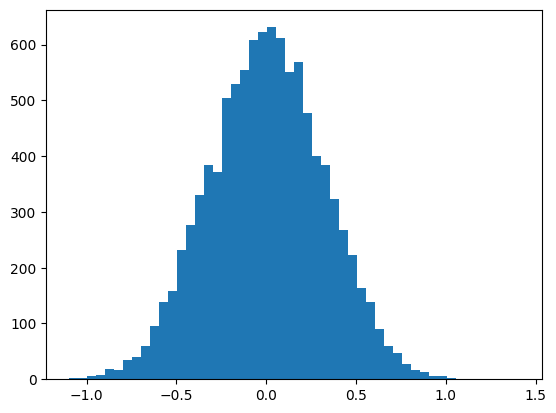

In [ ]:
plt.hist(output.flatten()[:100_000].detach().cpu(), bins=50);

In [ ]:
output = logits[0, 0]
print(output.min(), output.max())

scores = output.softmax(dim=0)
print(scores.min(), scores.max()) # 1/10_000

tensor(-1.1000, device='cuda:0', grad_fn=<MinBackward1>) tensor(1.4111, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(3.1514e-05, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0004, device='cuda:0', grad_fn=<MaxBackward1>)


In [ ]:
print(F.cross_entropy(output, y_batch[0, 0].to(device).long()))
F.cross_entropy(logits.view(-1, logits.shape[-1]), y_batch.flatten().to(device).long())

tensor(9.7177, device='cuda:0', grad_fn=<NllLossBackward0>)


tensor(9.2816, device='cuda:0', grad_fn=<NllLossBackward0>)

#Evaluate

In [ ]:
model.eval()

# with torch.no_grad():
with torch.inference_mode():
    for iter, (x_batch, y_batch) in enumerate(valid_loader):
        logits = model(x_batch.to(device))
        loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), y_batch.flatten().to(device).long())
        print(loss.item())
        if iter > 10:
            break

9.281440734863281
9.285577774047852
9.276803016662598
9.286075592041016
9.27902889251709
9.264440536499023
9.269034385681152
9.269050598144531
9.282246589660645
9.274201393127441
9.276554107666016
9.283934593200684


#Generate

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [ ]:
model.train()

for iter, (x_batch, y_batch) in enumerate(train_loader):
    logits = model(x_batch.to(device))
    loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), y_batch.flatten().to(device).long())
    print(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if iter > 100:
        break

9.278118133544922
8.597414016723633
8.211289405822754
7.890458106994629
9.73544979095459
7.5210957527160645
7.385534286499023
7.208658218383789
6.996175765991211
6.836503028869629
6.665106773376465
6.484945774078369
6.299807071685791
6.179881572723389
6.035385608673096
5.908625602722168
5.788937091827393
5.646618843078613
5.581595420837402
5.5015058517456055
5.403515338897705
5.385492324829102
5.327288627624512
5.281932830810547
5.268215179443359
5.236766815185547
5.183429718017578
5.209318161010742
5.145173072814941
5.182599067687988
5.134286403656006
5.1585211753845215
5.123717308044434
5.042187690734863
5.086205005645752
5.011716842651367
5.059130668640137
5.02794075012207
5.020962238311768
4.976663589477539
4.996017932891846
4.888437271118164
5.045689582824707
5.015349388122559
4.957878112792969
4.976004600524902
4.977469444274902
4.872124195098877
4.893512725830078
4.855453014373779
4.876060962677002
4.886102199554443
4.838363170623779
4.81147575378418
4.783895015716553
4.74278783

In [ ]:
max_seq_len = 128

prompt = 'In last night'
tokens = tokenizer.encode(prompt).ids
tokens = torch.tensor(tokens, dtype=torch.int, device=device).unsqueeze(0)
print(tokens)

model.eval()
with torch.inference_mode():
    for i in range(max_seq_len):
        logits = model(tokens)
        scores = logits[0, [-1]].softmax(dim=-1)
        idx = scores.argmax(keepdims=True)
        tokens = torch.cat((tokens, idx), dim=-1)

tokenizer.decode(tokens[0].tolist())

tensor([[   1,   32,   17, 1048,  398]], device='cuda:0', dtype=torch.int32)


'In last night.\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n'

In [ ]:
max_new_tokens = 50
# eos_token_id is available in HuggingFace
eos_id = getattr(tokenizer, "eos_token_id", None)
prompt = "Last night, "

ids = tokenizer.encode(prompt)                           # int
tokens = torch.tensor(ids, dtype=torch.long, device=device).unsqueeze(0)  # (B,T)

model.eval()
with torch.inference_mode():
    for _ in range(max_new_tokens):
        outputs = model(tokens)                          # logits = model(tokens)
        logits = outputs.logits if hasattr(outputs, "logits") else outputs[0]
        next_token_logits = logits[:, -1, :]             #(B,V): just last step

        probs  = torch.softmax(next_token_logits, dim=-1)
        next_id = torch.argmax(probs, dim=-1, keepdim=True)  # (B,1)

        tokens  = torch.cat([tokens, next_id], dim=-1)       # (B,T+1)
        if eos_id is not None and (next_id == eos_id).all():
            break

text = tokenizer.decode(tokens[0].tolist(), skip_special_tokens=True)
print(text)


Last night,  I was in the middle of a long day of work, and I was sitting in the middle of the street, and I was thinking about the future of the city. I was thinking about the future of the city. I was thinking about the


In [ ]:
max_new_tokens = 50
eos_id = getattr(tokenizer, "eos_token_id", None)
prompt = "Last night, "

ids = tokenizer.encode(prompt)
tokens = torch.tensor(ids, dtype=torch.long, device=device).unsqueeze(0)

model.eval()
with torch.inference_mode():
    outputs = model(tokens)
    past = getattr(outputs, "past_key_values", None)
    generated = tokens

    for _ in range(max_new_tokens):
        logits = outputs.logits
        next_token_logits = logits[:, -1, :]

        probs = torch.softmax(next_token_logits, dim=-1)
        next_id = torch.argmax(probs, dim=-1, keepdim=True)   # (B,1)

        generated = torch.cat([generated, next_id], dim=-1)

        if eos_id is not None and (next_id == eos_id).all():
            break

        # + past: just give the last one to the model
        outputs = model(input_ids=next_id, past_key_values=past)
        past = getattr(outputs, "past_key_values", None)

text = tokenizer.decode(generated[0].tolist(), skip_special_tokens=True)
print(text)


Last night,  I was in the middle of a long day of work, and I was sitting in the middle of the street, and I was thinking about the future of the city. I was thinking about the future of the city. I was thinking about the
